In [3]:
import logging
import time
import matplotlib.pyplot as plt
import cflib.crtp
import numpy as np

from cflib.crazyflie import Crazyflie
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.utils import uri_helper
import cflib.crtp
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncLogger import SyncLogger

URI = uri_helper.uri_from_env(default='radio://0/80/2M/E7E7E7E7E7')

# Only output errors from the logging framework
logging.basicConfig(level=logging.ERROR)

In [4]:
class FlipPlanner:
    def __init__(self, FLIP=1):
        if (FLIP==1):
            print("SINGLE FLIP, PLEASE CALCULATE")
            self.Phi_g1 = 180
            self.Phi_g2 = 0
            self.Phi_g3 = 180
            self.omega_max = 1400
            self.asc_time = 0.21
            self.duration = 0.49
        if (FLIP==2):
            print("DOUBLE FLIP, PLEASE CALCULATE")
            self.Phi_g1 = 200
            self.Phi_g2 = 300
            self.Phi_g3 = 220
            self.omega_max = 1600
            self.asc_time = 0.25
            self.duration = 0.75
        if (FLIP==3):
            print("TRIPLE FLIP, PLEASE CALCULATE")
            self.Phi_g1 = 220
            self.Phi_g2 = 520
            self.Phi_g3 = 340
            self.omega_max = 2000
            self.asc_time = 0.3
            self.duration = 0.8 

    def calculateStages(self):
        # Stage 1
        self.gamma1 = self.Phi_g1/self.omega_max
        self.beta1 = -(3/4)*self.omega_max/self.gamma1**3
        self.omega_dot_max1 = (3/4)*self.omega_max**2/self.Phi_g1
        self.delta1 = 2*self.gamma1
        # Stage 2
        self.delta2 = self.Phi_g2/self.omega_max
        # Stage 3
        self.gamma3 = self.Phi_g3/self.omega_max
        self.beta3 = -(3/4)*self.omega_max/self.gamma3**3
        self.omega_dot_max3 = (3/4)*self.omega_max**2/self.Phi_g3
        self.delta3 = 2*self.gamma3
        print("CALCULATED, RUN")

    def generateTraj2(self, t, phi_g):
        """ Generates reference angular rate trajectory 
        considering generalized flipping angle

        :param t: time since starting flipping
        :param phi_g: generalized flipping angle

        """
        omega_max = self.omega_max
        Phi_g1 = self.Phi_g1
        Phi_g2 = self.Phi_g2
        Phi_g3 = self.Phi_g3
        # Stage 1
        gamma1 = self.gamma1
        beta1 = self.beta1
        delta1 = self.delta1
        # Stage 2
        # Stage 3
        gamma3 = self.gamma3
        beta3 = self.beta3  
        delta2n = -1
        if phi_g <= Phi_g1:
            omega_d = beta1*(t - gamma1)**3/3 - beta1*gamma1**2*t + beta1*gamma1**3/3
            omega_dot_d = beta1*(t - gamma1)**2 - beta1*gamma1**2
            if t >= delta1:
                omega_d = omega_max
                omega_dot_d = 0
            print("P1")
            
        if (phi_g > Phi_g1) and (phi_g <= (Phi_g1 + Phi_g2)):
            omega_d = omega_max
            omega_dot_d = 0
            print("P2")

        if (phi_g > (Phi_g1 + Phi_g2)) and (phi_g <= (Phi_g1 + Phi_g2 + Phi_g3)):
            if delta2n == -1:
                delta2n = t # actual end time of stage 2

            omega_d = beta3*(gamma3 + delta2n - t)**3/3 - beta3*gamma3**2*(2*gamma3 + delta2n - t) + beta3*gamma3**3/3
            omega_dot_d = -beta3*(gamma3 + delta2n - t)**2 + beta3*gamma3**2
            print("P3")

        if phi_g > (Phi_g1 + Phi_g2 + Phi_g3):
            omega_d = 0
            omega_dot_d = 0
            
        return omega_d

    def generateTraj1(self, t):
        """ Generates reference angular rate trajectory 
        w/o considering generalized flipping angle

        :param t: time since starting flipping

        """        
        omega_max = self.omega_max
        Phi_g1 = self.Phi_g1
        Phi_g2 = self.Phi_g2
        Phi_g3 = self.Phi_g3
        # Stage 1
        gamma1 = self.gamma1
        beta1 = self.beta1
        delta1 = self.delta1
        # Stage 2
        delta2 = self.delta2
        # Stage 3
        gamma3 = self.gamma3
        beta3 = self.beta3  
        delta3 = self.delta3

        if t <= delta1:
            omega_d = beta1*(t - gamma1)**3/3 - beta1*gamma1**2*t + beta1*gamma1**3/3
            omega_dot_d = beta1*(t - gamma1)**2 - beta1*gamma1**2
            if t >= delta1:
                omega_d = omega_max
                omega_dot_d = 0

        if (delta1 < t and t <= delta1 + delta2):
            omega_d = omega_max
            omega_dot_d = 0

        if (delta1 + delta2 < t and t <= delta1 + delta2 + delta3):
            delta2n = delta1 + delta2
            omega_d = beta3*(gamma3 + delta2n - t)**3/3 - beta3*gamma3**2*(2*gamma3 + delta2n - t) + beta3*gamma3**3/3
            omega_dot_d = -beta3*(gamma3 + delta2n - t)**2 + beta3*gamma3**2

        if t > delta1 + delta2 + delta3:
            omega_d = 0
            omega_dot_d = 0
            
        return omega_d

SINGLE FLIP, PLEASE CALCULATE
CALCULATED, RUN


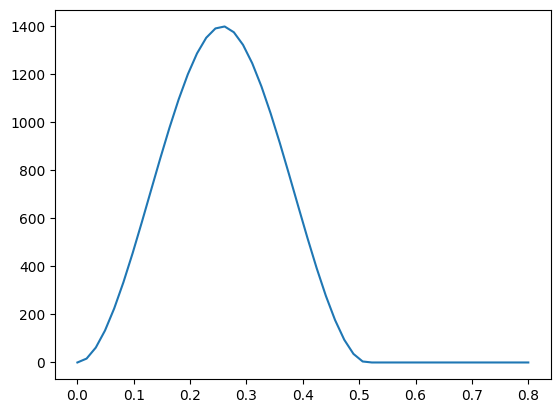

In [5]:
# TEST FUNCTIONS
planner = FlipPlanner(FLIP=1)
planner.calculateStages()
# print(vars(planner))
import numpy as np
t = np.linspace(0, 0.8)
rate = map(planner.generateTraj1, t)
# rate = map(lambda x: 2*x, list(t))
rate = np.array(list(rate))
plt.plot(t,list(rate))


In [49]:
### ROLL FLIP ###
log_keys = ['controller.rollRate','stateEstimateZ.rateRoll','stateEstimate.roll']
# log_keys = ['stateEstimateZ.x', 'stateEstimateZ.y', 'stateEstimateZ.z']

lg_stab = LogConfig(name='flip', period_in_ms=10)
lg_data = {}
for key in log_keys:
    lg_stab.add_variable( key, 'float')
    lg_data[key.split('.')[1]] = []

if __name__ == '__main__':
    # Initialize the low-level drivers
    planner = FlipPlanner(FLIP=1)
    planner.calculateStages()

    cflib.crtp.init_drivers(enable_debug_driver=False)
    with SyncCrazyflie(URI, cf=Crazyflie(rw_cache='./cache')) as scf:
        cf = scf.cf
        h = 0.9   # stabilization height TODO: for each case

        # print('Initializing as PID')
        cf.param.set_value('stabilizer.controller', '1')
        cf.param.set_value('posCtlPid.zKp', '3.0')

        cf.param.set_value('kalman.resetEstimation', '1')
        time.sleep(0.1)
        cf.param.set_value('kalman.resetEstimation', '0')
        time.sleep(2)

        # print('Reset Kalman filter.')
        print('Taking off!')
        cf.commander.send_setpoint(0, 0, 0, 0)

        # drone take off to a height
        for y in range(10):        
            cf.commander.send_hover_setpoint(0, 0, 0, h*y/10)
            time.sleep(0.1)

        for _ in range(50):
            cf.commander.send_hover_setpoint(0, 0, 0, h)
            time.sleep(0.1)


        # execute trajectory
        # step 1: ascend
        print('Ascending!')
        asc_time = planner.asc_time
        asc_thrust = 60000  # max thrust
        t_start = time.time()
        while True:
            t_current = time.time()
            t = abs(t_current-t_start)  # time since starting flipping
            if t > asc_time:
                break
            # cf.commander.send_setpoint(0, 0, 0, asc_thrust)
            cf.commander.send_hover_setpoint(0, 0, 0, 3*h)

        # step 2: flip (tracking desired angular rate)
        print('Flipping!')
        # cf.param.set_value('pid_rate.roll_kp', '400')
        # cf.param.set_value('pid_rate.roll_ki', '170')
        # cf.param.set_value('pid_rate.roll_kd', '15')
        cf.param.set_value('flightmode.stabModeRoll', '0')    # to rate mode
        cf.param.set_value('stabilizer.tumbleCheckEn', '0')    # disable tumble check

        waypoints = []
        time_list = []
        # TODO: take flipping angle to switch trajectory
        with SyncLogger(scf, lg_stab) as logger:
            t_start = time.time()
            flip_thrust = 40000

            for log_entry in logger:
                t_current = time.time()
                t = abs(t_current-t_start)  # time since starting flipping

                for key, value in log_entry[1].items():
                    lg_data[key.split('.')[1]].append(value)

                w = 1*planner.generateTraj1(t+0.03)
                waypoints.append(w)     
                time_list.append(t)       

                if t <= planner.duration:                    
                    cf.commander.send_setpoint(w,0,0,flip_thrust)
                    # time.sleep(0.05)    # TODO: what is the max frequency
                elif t <= planner.duration + 0.1:      
                    # step 3: stabilize
                    # at a height
                    # print('Stabilizing!')
                    # cf.param.set_value('pid_rate.roll_kp', '250')
                    # cf.param.set_value('pid_rate.roll_ki', '500')
                    # cf.param.set_value('pid_rate.roll_kd', '2.5')        
                    cf.param.set_value('flightmode.stabModeRoll', '1')    # to angle mode
                    # cf.param.set_value('stabilizer.controller', '3')
                    cf.param.set_value('stabilizer.tumbleCheckEn', '1')    # enable tumble check
                    cf.commander.send_hover_setpoint(0, 0, 0, 2.5)
                elif t <= planner.duration + 3:   
                    cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
                else:
                    break
        # drone landing
        print("Landing!")
        for y in range(10):
            cf.commander.send_hover_setpoint(0, 0, 0, (10 - y)*h / 10)
            time.sleep(0.1)

        cf.commander.send_stop_setpoint()

        # print(waypoints)
        # print(time_list)

SINGLE FLIP, PLEASE CALCULATE
CALCULATED, RUN
Taking off!
Ascending!
Flipping!
Landing!


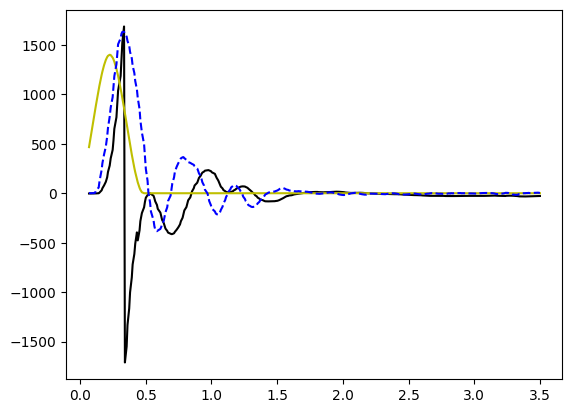

In [34]:
# plt.plot(time_list,180*np.ones(len(time_list)))

# plt.plot(time_list, np.array(lg_data['x'])/1000,'b--',time_list, np.array(lg_data['y'])/1000,'r')
# plt.figure()
# plt.plot(time_list, np.array(lg_data['z'])/1000)

plt.plot(time_list, np.array(lg_data['roll'])*10,'k',time_list,waypoints,'y',time_list, np.array(lg_data['rateRoll'])*180/3.14/1000,'b--')
# plt.plot(time_list, -np.array(lg_data['pitch'])*10,'k',time_list,waypoints,'y', time_list, -np.array(lg_data['pitchRate']),'r',time_list, -np.array(lg_data['ratePitch'])*180/3.14/1000,'b--')

# plt.figure()
# plt.plot(,time_list, lg_data['rollRate'],'b--')
# plt.figure()
# plt.plot(time_list, lg_data['roll'])


In [48]:
# print('Saving data...')
# for key in lg_data.keys():
#     lg_data[key] = np.array(lg_data[key])

# np.savez('quad_data/quad_traj', **lg_data)
# np.savez('quad_data/timelist', np.array(time_list))
from numpy import load

data = load('quad_data/timelist.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

arr_0
[0.06942821 0.08318782 0.08898187 0.09545922 0.10415816 0.11575294
 0.12224627 0.1430769  0.14808941 0.15477061 0.16532755 0.17122459
 0.18393159 0.19723487 0.20753932 0.21365881 0.22675323 0.23430204
 0.2491138  0.25546145 0.26201057 0.27800941 0.28429985 0.29050684
 0.30992317 0.316293   0.32280898 0.33586335 0.34236073 0.35560155
 0.36205029 0.37507606 0.38158941 0.39471436 0.40119171 0.41416645
 0.42088628 0.43363738 0.44018555 0.4538579  0.45995069 0.47146177
 0.4882431  0.49487257 0.5015099  0.51468897 0.52077961 0.53380871
 0.54030681 0.56001472 0.56651545 0.57295537 0.58604789 0.59236217
 0.61213851 0.61850023 0.62497616 0.63779736 0.64457035 0.65080667
 0.66434979 0.67028618 0.68982363 0.69643354 0.70293188 0.71604872
 0.72243667 0.73534346 0.74839568 0.76151896 0.76808071 0.78116083
 0.78759933 0.79428935 0.81018329 0.81691384 0.82342863 0.83970881
 0.84639096 0.85278153 0.86593866 0.87247252 0.89245391 0.8988049
 0.90564919 0.91839719 0.92485237 0.93130326 0.94470739 0

KeyError: 'waypoints is not a file in the archive'

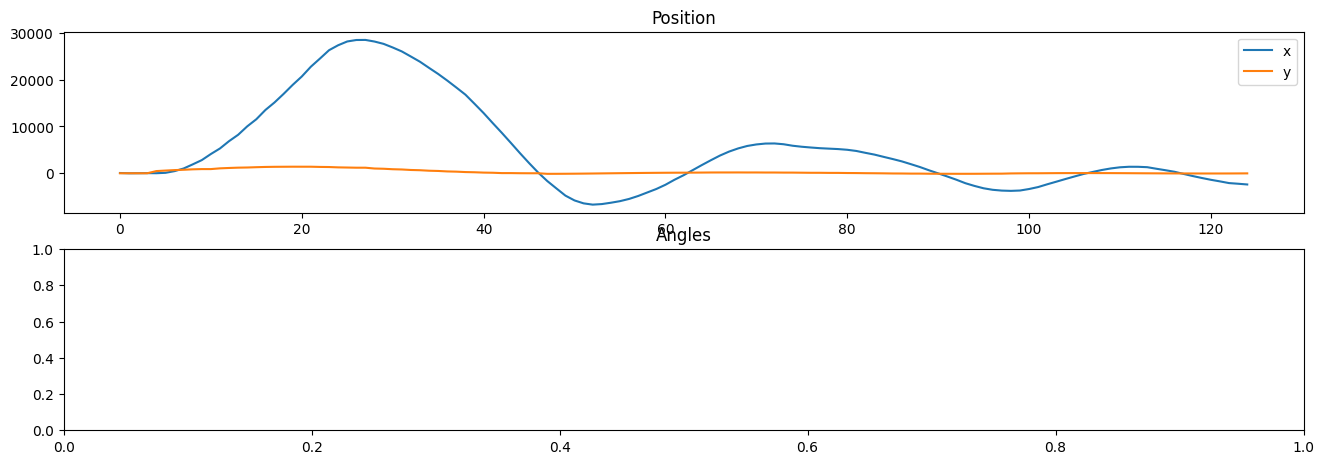

In [43]:
import os

if os.path.isfile('quad_data/quad_traj.npz'):
    npzfile = np.load('quad_data/quad_traj.npz')

    plt.rcParams["figure.figsize"] = (16,8)
    fig = plt.figure()

    ax = fig.add_subplot(311, title='Position')
    ax.plot(npzfile['rateRoll'][:125], label='x')
    ax.plot(npzfile['rollRate'][:125], label='y')
    ax.legend()

    ax = fig.add_subplot(312, title='Angles')
    ax.plot(npzfile['waypoints'][:125], label='phi')
    ax.plot(npzfile['time_list'][:125], label='theta')
    ax.legend()

    # ax = fig.add_subplot(313, title='Moments')
    # ax.plot(npzfile['u2_pwm'][:125] / (2 ** 15), label='M1')
    # ax.plot(npzfile['u3_pwm'][:125] / (2 ** 15), label='M2')
    # ax.legend()
else:
    print('No flight data found.')